In [1]:
import torch, timm
from torchvision import transforms as tfs
from torchvision.datasets import ImageFolder
from glob import glob
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
import numpy as np

In [2]:
root = "/mnt/C6E2920FE29203B9/din/Deep_l/1_classification/1_data/nuts/"
t = tfs.Compose([tfs.Resize((224,224)),
                 tfs.ToTensor()])
ds = ImageFolder(root=root, transform=t)
ds_length = len(ds)
bs = 32
tr_ds, val_ds = torch.utils.data.random_split(ds, [int(ds_length * 0.8), ds_length-int(ds_length * 0.8)])
print(f"Number of train set images: {len(tr_ds)}")
print(f"Number of validation set images: {len(val_ds)}")
cls_names = list(ds.class_to_idx.keys())
num_classes = len(cls_names)
train_loader = DataLoader(tr_ds, batch_size=bs)
test_loader = DataLoader(val_ds, batch_size=bs)

Number of train set images: 974
Number of validation set images: 244


# Data Analysis

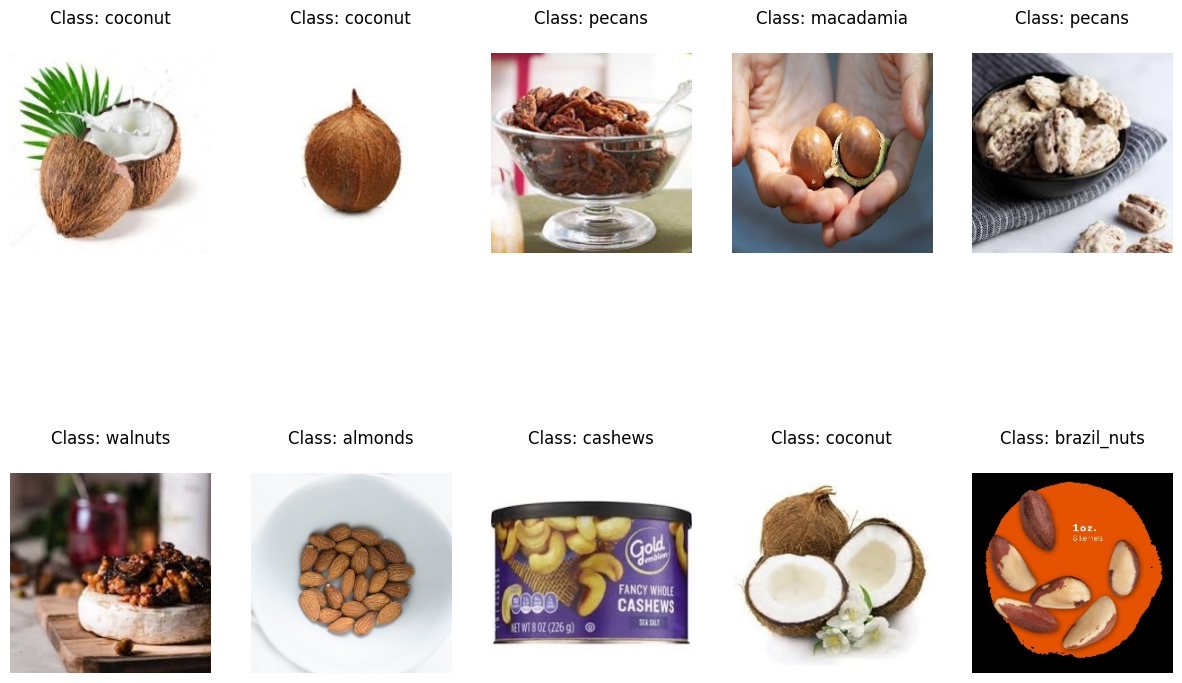

In [3]:
from matplotlib import pyplot as plt

cnt, num = 0, 10
plt.figure(figsize=(15,10))

for i, data in enumerate(tr_ds):

    if i == num:
        break
    im, lbl = data
        
    if num % 2 == 0:
        plt.subplot(2, int(num / 2), i + 1)
        plt.imshow((im*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8))
        plt.axis('off')
        plt.title(f"Class: {cls_names[lbl]}\n")
    else:
        plt.subplot(2, int(num / 2), i + 1)
        plt.imshow((im*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8))
        plt.axis('off')
        plt.title(f"Class: {cls_names[lbl]}")

# Inference

In [4]:
def inference(model_name, num_classes, checkpoint_path, device, dl):
    
    predictions, gts, images = [], [], []
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    model.to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    print("Model checkpoint loaded successfully!")
    
    correct, total = 0, 0
    for idx, batch in tqdm(enumerate(dl)):
        ims, lbls = batch
        preds = model(ims.to(device))
        images.extend(ims.to(device))
        _, predicted = torch.max(preds.data, 1)
        predictions.extend(predicted)
        gts.extend(lbls.to(device))
        total += lbls.size(0)
        correct += (predicted == lbls.to(device)).sum().item()        
        
    print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')  
    
    return model, torch.stack(predictions), torch.stack(gts), torch.stack(images)

checkpoint_path = "./resnet50_Adam/checkpoint_21_best.pth"
device='cuda:0'
m, predictions, gts, images = inference('resnet50', num_classes, checkpoint_path, device, test_loader)

Model checkpoint loaded successfully!


8it [00:15,  1.93s/it]

Accuracy of the network on the 244 test images: 92 %


# Visualization

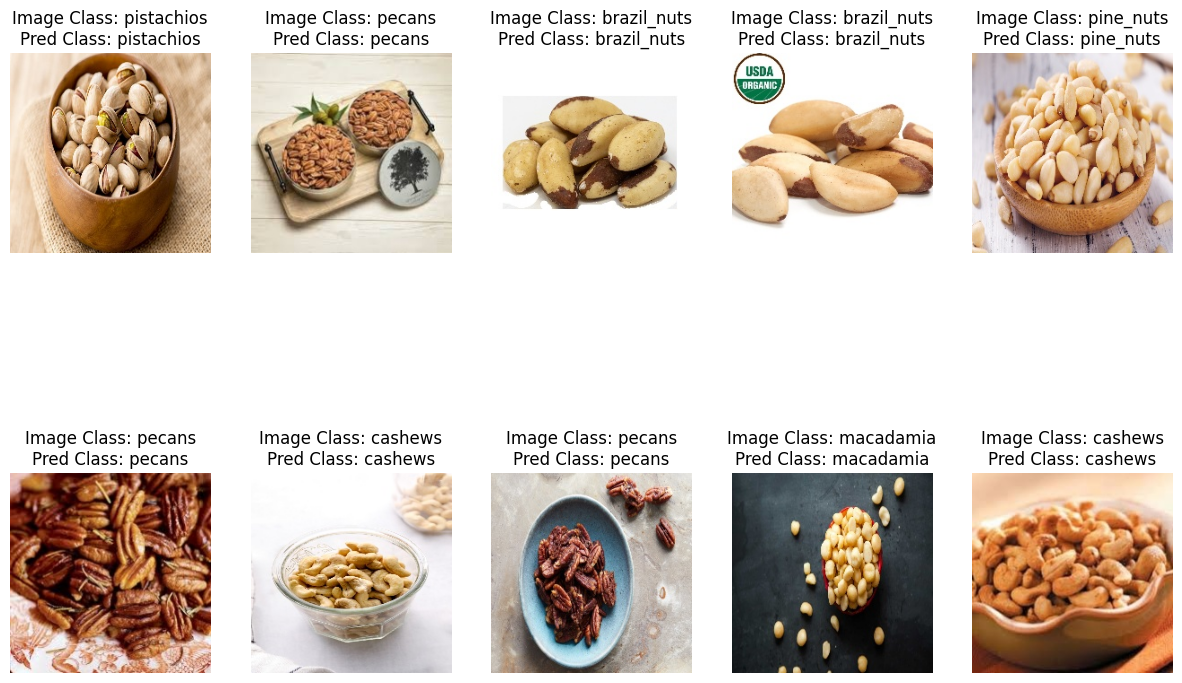

In [5]:
from matplotlib import pyplot as plt

cnt, num = 0, 10
plt.figure(figsize=(15,10))

for i, im in enumerate(images):
    if i == num:
        break
        
    if num % 2 == 0:
        plt.subplot(2, int(num / 2), i + 1)
        plt.imshow((im*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8))
        plt.axis('off')
        plt.title(f"Image Class: {cls_names[gts[i]]}\nPred Class: {cls_names[predictions[i]]}")
    else:
        plt.subplot(2, int(num / 2), i + 1)
        plt.imshow((im*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8))
        plt.axis('off')
        plt.title(f"Image Class: {cls_names[gts[i]]}\nPred Class: {cls_names[predictions[i]]}")

# GradCAM


	Input Image 			  GradCAM


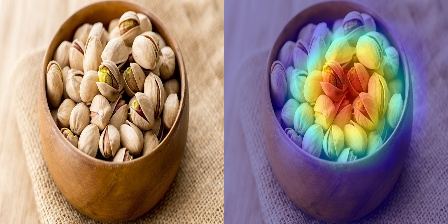


	Input Image 			  GradCAM


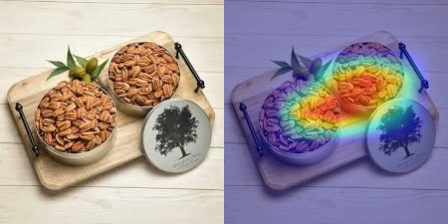


	Input Image 			  GradCAM


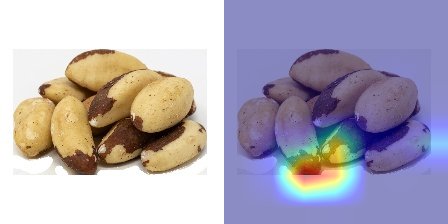


	Input Image 			  GradCAM


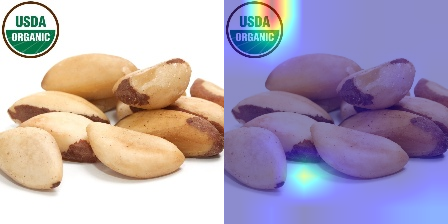


	Input Image 			  GradCAM


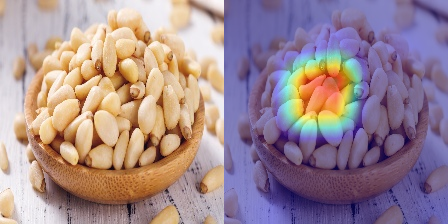


	Input Image 			  GradCAM


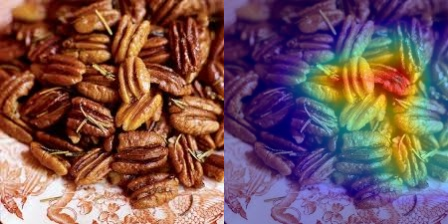


	Input Image 			  GradCAM


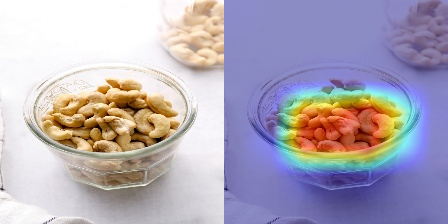


	Input Image 			  GradCAM


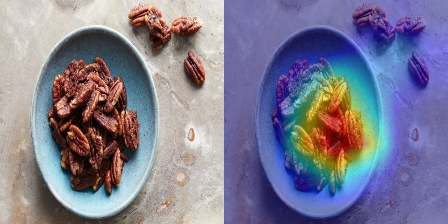


	Input Image 			  GradCAM


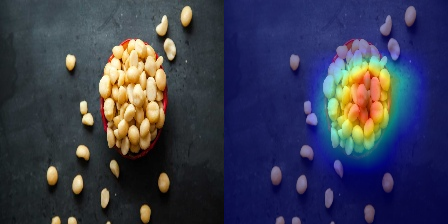


	Input Image 			  GradCAM


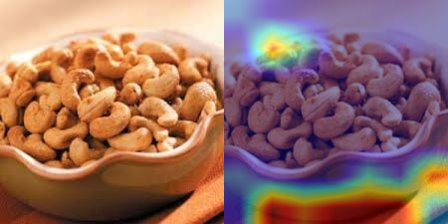

In [8]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

m.to(device)
m.eval()
cam = GradCAM(model=m, target_layers=[m.layer4[-1]], use_cuda=False)

for i, im in enumerate(images):
    if i == num:
        break
    print('\n\tInput Image \t\t\t  GradCAM')
    grayscale_cam = cam(input_tensor=im.unsqueeze(0).to(device))
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image((im*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)/255, grayscale_cam, image_weight=0.55, colormap=2, use_rgb = True)
    ori_im = (images[i]*255).cpu().numpy().transpose([1,2,0]).astype(np.uint8)
    
    display(Image.fromarray(np.concatenate([ori_im,visualization], axis=1)))